## Silicon above 15 m

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

In [2]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [3]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values

In [4]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [5]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [6]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [7]:
def slope_inter(df, obs, mod):
    X = df[obs]
    X2 = X**2
    y = df[mod]
    X = np.column_stack((X, X2))
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
     
    return predictions, model.params['x2'], model.params['x1'], model.params['const'], systematic, nonsyst

In [8]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [9]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [10]:
def plot_and_stats(temp1, name, idepth, jdepth):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 90
    vmin = 0
    condition = (temp1.k >= idepth) & (temp1.k <= jdepth)
    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1.Si[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1.mod_silicon[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 1), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'Si', 'mod_silicon')
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'Si', 'mod_silicon')
    tswillmott = swillmott(temp1[temp1.k >=idepth], 'Si', 'mod_silicon')
    predictions, m2, m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'Si', 'mod_silicon')
    tspread = spread(temp1[temp1.k >= idepth], 'Si', 'mod_silicon')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(temp1.Si[condition], predictions, 'r.');
    sc = 5
    sh = 2*sc-1
    bot = 65
    top = bot + 2*sh 
    ax.arrow(5, bot, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(5, top, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(9, bot, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(9, top, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(13, bot, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(13, top, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(5-1.2, 48, 'bias', rotation=90)
    ax.text(9-1.2, 48, 'systematic', rotation=90)
    ax.text(13-1.2, 42, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Silicon between 0 and 15 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [11]:
pieces = ('/home/sallen/202007/H201812/ObsModel_201812_Bio_20150101-20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_Bio_20160101-20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_Bio_20170101-20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201812_PSF_20160101-20161231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201812_PSF_20170101-20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20170101_20171231.csv')

0.5000002726327963 14.568982157803276


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,2912,-1.1,1.5e+01,0.24,0.31,1.8e+01,1.4e+01,7.0,0.65


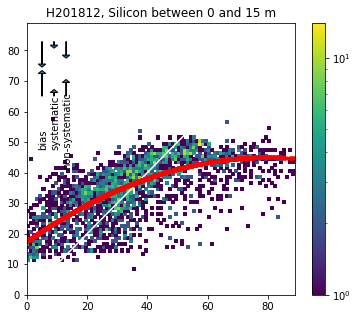

In [12]:
temp1 = read_pieces(pieces)
temp1['Si'] = temp1.Si.fillna(value=temp1['Silicate [umol/L]'])
idepth = 0
jdepth = 14
d201812 = plot_and_stats(temp1, 'H201812', idepth, jdepth)
d201812.style.format(myformat)

In [13]:
pieces = ('/home/sallen/202007/H201905/ObsModel_201905_Bio_20150101-20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_Bio_20160101-20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_Bio_20170101-20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201905_PSF_20160101-20161231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201905_PSF_20170101-20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20170101_20171231.csv')

0.5000002726327963 14.568982157803276


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,2912,-9.8,1.9e+01,0.27,0.26,7.1,1.6e+01,1.1e+01,0.36


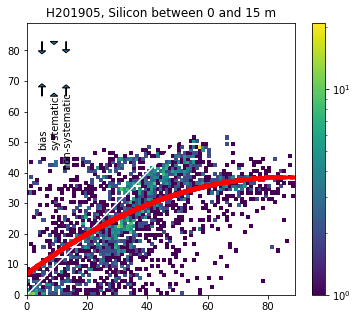

In [14]:
temp1 = read_pieces(pieces)
temp1['Si'] = temp1.Si.fillna(value=temp1['Silicate [umol/L]'])

d201905 = plot_and_stats(temp1, 'H201905', idepth, jdepth)
d201905.style.format(myformat)

In [15]:
pieces = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20150101-20151231.csv',
 #        '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20160101-20161231.csv',
 #        '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20170101_20171231.csv')

0.5000002726327963 14.568982157803276


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp2,2912,-1.6e+01,2.2e+01,0.27,0.25,-0.54,2e+01,9.3,0.18


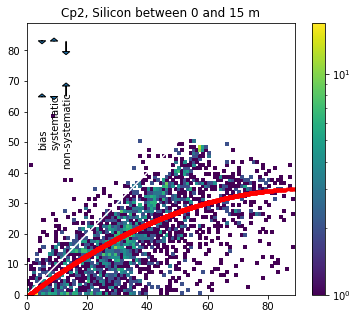

In [16]:
temp1 = read_pieces(pieces)
temp1['Si'] = temp1.Si.fillna(value=temp1['Silicate [umol/L]'])
dCp2 = plot_and_stats(temp1, 'Cp2', idepth, jdepth)
dCp2.style.format(myformat)

In [17]:
pieces = ('/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_bot_20150101_20151231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_bot_20160101_20161231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20150101_20150331.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20150401_20150630.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_PSF_20150701-20151231.csv',
#          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20160101_20161231.csv',
#          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20150101_20150331.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20150401_20150630.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_PUG_20150701-20151231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_hplc_20170101_20171231.csv')

0.5000002726327963 14.568982157803276


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp3,2892,-1.7e+01,2.2e+01,0.27,0.29,-0.6,2e+01,9.4,0.16


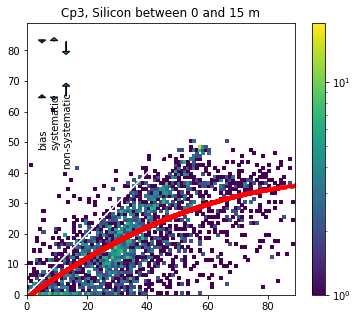

In [18]:
temp1 = read_pieces(pieces)
temp1['Si'] = temp1.Si.fillna(value=temp1['Silicate [umol/L]'])
dCp3 = plot_and_stats(temp1, 'Cp3', idepth, jdepth)
dCp3.style.format(myformat)

In [19]:
pieces = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20160101-20161231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20170101-20171231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20160101-20161231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20170101-20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20170101_20171231.csv'
        )

0.5000002726327963 14.568982157803276


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Dagain,2912,-9.6,1.9e+01,0.26,0.17,6.6,1.6e+01,9.0,0.46


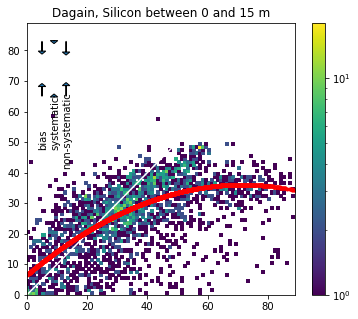

In [20]:
temp1 = read_pieces(pieces)
temp1['Si'] = temp1.Si.fillna(value=temp1['Silicate [umol/L]'])
Dagain = plot_and_stats(temp1, 'Dagain', idepth, jdepth)
Dagain.style.format(myformat)

In [21]:
pieces = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_bot_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_PSF_20150101-20151231.csv',
 #        '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psf_20160101_20161231.csv',
 #        '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20170101_20171231.csv')

0.5000002726327963 14.568982157803276


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-lowR,2912,-1.5e+01,2.2e+01,0.27,0.27,0.84,1.9e+01,1e+01,0.19


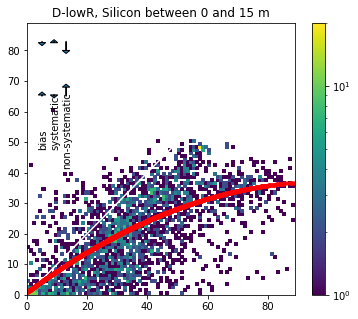

In [22]:
temp1 = read_pieces(pieces)
temp1['Si'] = temp1.Si.fillna(value=temp1['Silicate [umol/L]'])
DlowR = plot_and_stats(temp1, 'D-lowR', idepth, jdepth)
DlowR.style.format(myformat)

In [23]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_bot_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psf_20150101_20151231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20160101_20161231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20170101_20171231.csv')

0.5000002726327963 14.568982157803276


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,2912,-1.7e+01,2.2e+01,0.26,0.4,-0.46,2e+01,9.7,0.096


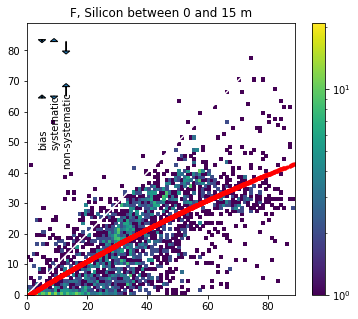

In [24]:
temp1 = read_pieces(pieces)
temp1['Si'] = temp1.Si.fillna(value=temp1['Silicate [umol/L]'])
modF = plot_and_stats(temp1, 'F', idepth, jdepth)
modF.style.format(myformat)

In [25]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [27]:
alltogether = pd.concat([d201812, d201905, dCp2, dCp3, Dagain, DlowR, modF], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,2912,-1.1,1.5e+01,0.24,0.31,1.8e+01,1.4e+01,7.0,0.65
H201905,2912,-9.8,1.9e+01,0.27,0.26,7.1,1.6e+01,1.1e+01,0.36
Cp2,2912,-1.6e+01,2.2e+01,0.27,0.25,-0.54,2e+01,9.3,0.18
Cp3,2892,-1.7e+01,2.2e+01,0.27,0.29,-0.6,2e+01,9.4,0.16
Dagain,2912,-9.6,1.9e+01,0.26,0.17,6.6,1.6e+01,9.0,0.46
D-lowR,2912,-1.5e+01,2.2e+01,0.27,0.27,0.84,1.9e+01,1e+01,0.19
F,2912,-1.7e+01,2.2e+01,0.26,0.4,-0.46,2e+01,9.7,0.096


**Conclusion** None of these look great.  The increase in Si in F doesn't seem to have decreased the bias, but has improved the spread.  The systematic line is as far from the correct straight line as ever, but it is more of a straight line